### Reverse Correlation Audio

The goal of this analysis is to create an audio file (that we can listen to), which contains 'footage' from the speech based on the brain response of the audience. In other words, we will cut together those parts of the speech, that make a particular brain region more active. This approach is sometimes called 'reverse correlation'. 

Because it is easy to get confused about this, let's unpack it a bit more: Normally, we would perform a 'forward analysis'. In such a forward analysis, one would take a content feature of the stimulus (e.g. the audio/RMSE feature) and ask: Which brain region tracks with this? A reverse correlation is different in its goal, and different in its approach: Rather than going from the stimulus to the brain (forward), we now will go from the brain response back to the stimulus. 

Thus, we will zoom in on a particular region and ask first: At which moments is this brain region significantly engaged (or also to opposite: significantly suppressed/lowered)? We will then note the time-points for those segments, such as region1_peak1: 65-68 seconds, region1_peak2: 89-95 seconds, ..... With this time-sheet of 'moments of maximum regional brain activtity', we will then go back to the audio-recording of the speech, cut out the relevant segments, and create a new audio-file - pretty much like a "brain-based trailer of the speech". 

Then, we can listen to this trailer to see if we can identify a particular content element that seems to be present in this trailer.



In [1]:
import re, sys
import nilearn
from nilearn import plotting, input_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
sys.path.insert(1, '../')

from itsnotthefall_utils import *
import seaborn as sns
from nilearn.image import new_img_like
from scipy.io.wavfile import write

from IPython.display import Audio
from scipy.io import wavfile

from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/neuroimaging/lib/python3.9/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


### load audio and text

In [2]:
itsnotthefall_text = pd.read_csv('../data_itsnotthefall/01_audio_text/itsnotthefall.csv',
                       header = None, 
                       names  = ['text', 'emb_dict', 'onset_time', 'offset_time'],
                       encoding = "utf-8")

tr_shift = 3
tr = 1.5

itsnotthefall_text['tr'] = divmod(itsnotthefall_text['onset_time'].values, tr)[0] + tr_shift

print(itsnotthefall_text.head())


sound_file = '../data_itsnotthefall/01_audio_text/itsnotthefall.wav'
samplerate, sounddata = wavfile.read(sound_file)
#print(data.shape[0]/samplerate)
print(samplerate)

#Audio(sound_file,)  #uncommented to make notebook fit into anonymous github

       text  emb_dict  onset_time  offset_time    tr
0        So        so    3.590000     3.610000   5.0
1       I’m       i'm   25.910000    26.140000  20.0
2        um        um   26.139999    26.679999  20.0
3      five      five   27.050000    27.360000  21.0
4  thousand  thousand   27.360000    27.670000  21.0
44100


### load fMRI data

In [3]:
fmri_data = np.load('../data_itsnotthefall/03_extract_ts/fmri_data_itsnotthefall.npy')
print(fmri_data.shape)


data = fmri_data.copy()
data = np.swapaxes(data, 0,1)
data = np.swapaxes(data, 1,2)
print(data.shape)

shen_pauli_aan_file       = '../data_itsnotthefall/02_rois_masks_maps/allcombined.nii'
shen_pauli_aan_masker = nilearn.input_data.NiftiLabelsMasker(labels_img=shen_pauli_aan_file);
sample_file = '../data_itsnotthefall/02_rois_masks_maps/func.nii'
shen_pauli_aan_masker.fit_transform(sample_file);

(54, 388, 268)
(388, 268, 54)


### Define and plot three key regions: Auditory Cortex, TPJ, and N. accumbens

{'coords': [39.788649706457925, -25.643835616438352, 14.450097847358123], 'name': "31.31% Parietal_Operculum_Cortex; 24.07% Planum_Temporale; 21.33% Heschl's_Gyrus_(includes_H1_and_H2); 21.33% Insular_Cortex", 'index_label': 62, 'data_array_index': 61}


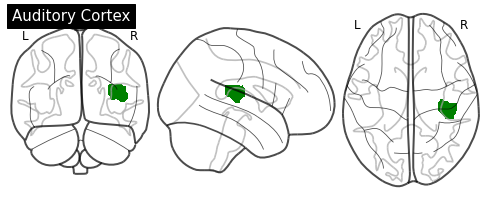

{'coords': [48.86702127659574, -58.01329787234043, 14.295212765957444], 'name': '35.64% Angular_Gyrus; 25.13% Middle_Temporal_Gyrus_temporooccipital_part; 22.21% Lateral_Occipital_Cortex_inferior_division; 16.62% Lateral_Occipital_Cortex_superior_division', 'index_label': 50, 'data_array_index': 49}


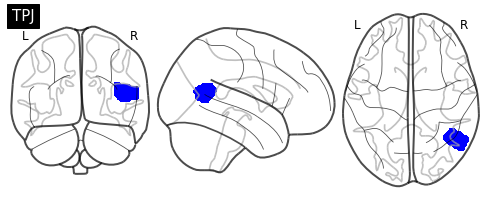

In [4]:
shen_pauli_aan_dict = np.load('../data_itsnotthefall/02_rois_masks_maps/shen_pauli_aan_dict.npy', allow_pickle=True).item()

key_regions         = [62, 50,]# 271]
key_regions_label   = ['Auditory Cortex', 'TPJ',]# 'N Accumbens']
colorlist           = ['green', 'blue', ]#'red']

for count in range(2):#3):  
    
    curr_region_dictidx = key_regions[count]
    print(shen_pauli_aan_dict[curr_region_dictidx])
    
    all_file       = '../data_itsnotthefall/02_rois_masks_maps/allcombined.nii'
    all_img        = nilearn.image.load_img(all_file)
    all_data       = all_img.get_fdata()

    all_data[np.where(all_data!= curr_region_dictidx)] = 0
    all_new_img    = new_img_like(all_img, all_data.astype(int))

    current_title  = key_regions_label[count]
    display = plotting.plot_glass_brain(None,
                                       title = current_title)
    display.add_contours(all_new_img, filled=True, colors=colorlist[count])
    plt.show()

### plot time courses from auditory cortex, TPJ, and N. accumbens

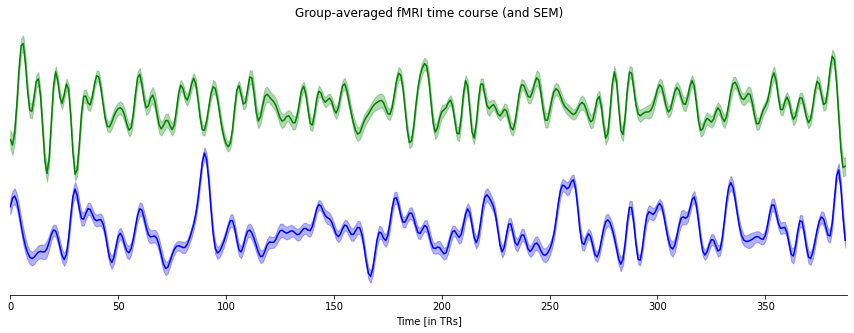

In [5]:
plt.figure(figsize= (15,5)); #15,8 if 3 regions

for count in range(2) :  
    curr_roi = shen_pauli_aan_dict[key_regions[count]]['data_array_index']

    curr_data = data[:,curr_roi,:]
    x = np.arange(curr_data.shape[0])
    y = np.mean(curr_data, axis =1) + ((2-count)*2.5) #this elevates where it is plotted 
    yerr = np.std(curr_data, axis =1)/np.sqrt(curr_data.shape[1])
    
    errorfill(x, y, yerr, color=colorlist[count]);

    
plt.title('Group-averaged fMRI time course (and SEM)');
plt.xlim([0,388])
plt.yticks([]) 
sns.despine(left=True);

green_patch = mpatches.Patch(color='green', label='Auditory')
blue_patch = mpatches.Patch(color='blue', label='TPJ')
red_patch = mpatches.Patch(color='red', label='Accumbens')

#plt.legend(handles=[green_patch,blue_patch,red_patch], loc = 5)
plt.xlabel('Time [in TRs]')
plt.show()


### Focus on [REGION] : Where are peaks and troughs?

TPJ


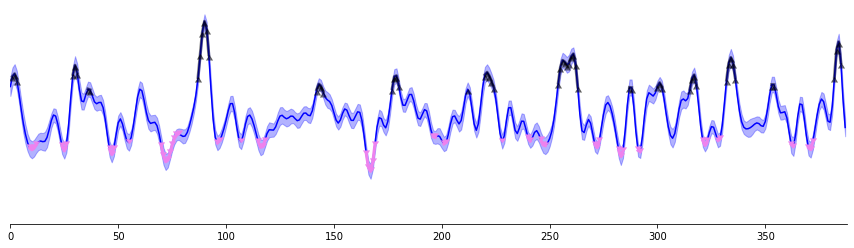

In [6]:
count = 1
#  1 - TPJ | 2- NAcc  

outname_region = key_regions_label[count]
print(outname_region)

curr_roi = shen_pauli_aan_dict[key_regions[count]]['data_array_index']

curr_data = data[:,curr_roi,:]
threshold = 3.29 # this is the stats threshold for 0.001

# we're doing essentially a point-by-point t-test
x = np.arange(curr_data.shape[0])
y = np.mean(curr_data, axis =1)
yerr = np.std(curr_data, axis =1)/np.sqrt(curr_data.shape[1])

# converting to z-scores (or: t-scores)
z   = y/yerr
z2  = z.copy()
zy  = z.copy()
z2y = z.copy()

# positive and negative thresholding
z[z<threshold] = np.nan
z[z>=threshold] = -1

z2[z2>-threshold] = np.nan
z2[z2<=threshold]  = -1

zy[zy<threshold] = np.nan
zy[z==-1] = y[z==-1]

z2y[z2!=-1]  = np.nan
z2y[z2==-1] = y[z2==-1]

# plot
plt.figure(figsize= (15,4));
errorfill(x, y, yerr, color= colorlist[count]);

plt.plot(zy, linewidth = 3, marker = 6, color = 'black', alpha = 0.5); #caretup

plt.plot(z2y, linewidth = 3,  marker = 7., color = 'violet', )#alpha = 0.5);
plt.xlim([0,388]);
plt.ylim([-1.8, 1.8]);
sns.despine(left = True)
plt.yticks([]);

### Identify the 'moments' (time segments) during which the fMRI signal maxed:

In [7]:
tr_peaks = np.where(z<0)
print(len(tr_peaks[0]))

tr_troughs = np.where(z2<0)
print(len(tr_troughs[0]))

58
60


In [8]:
# get peak location
tr_peaks = np.where(z<0)
sys.stdout.write('Peak moments (in TR): ')
print(', '.join(map(str, tr_peaks[0])))

high_res = []

# get text corresponding to peaks
#print('---')
for i in range(len(tr_peaks[0])):
    erg = itsnotthefall_text[itsnotthefall_text['tr'] == tr_peaks[0][i]]
    #print(str(i))
    #print(erg['text'].values)
    high_res.append(erg['text'].values)
#print('---')

high_res = [item for sublist in high_res for item in sublist]
sys.stdout.write('\nCorresponding text: ')
print(' - '.join(high_res))

# cut audio-trailer based on peak scenes
wavonsetseconds = (tr_peaks[0]- tr_shift)*tr
increment = tr*samplerate
wavonsetsamples = wavonsetseconds*samplerate

peakcut = []
for i in range(len(wavonsetsamples)):
    peakcut.extend( sounddata[ int(wavonsetsamples[i]):int((wavonsetsamples[i]+increment)) ] )
    
peakcut = np.asarray(peakcut)

wavtitle = '../data_itsnotthefall/04_rc_results/' + outname_region + '_Peaks.wav'
write(wavtitle, samplerate, peakcut)
#Audio(wavtitle, )

Peak moments (in TR): 1, 2, 3, 29, 30, 31, 36, 37, 87, 88, 89, 90, 91, 92, 142, 143, 144, 145, 177, 178, 179, 180, 212, 220, 221, 222, 223, 224, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 287, 288, 300, 301, 302, 315, 316, 317, 318, 332, 333, 334, 335, 336, 353, 354, 382, 383, 384, 385

Corresponding text: and - she’s - gone - with - the - plane - Um - first - thing - she - did - was - shake - my - hand - but - then - she - put - her - arm - through - mine - and - squeezed - it - a - little - bit - and - said - This - is - going - to - be - awesome - And - then - she - led - me - into - the - office - and - I - jump - off - of - it - and - my - feet - raise - these - two - little - kind - of - dust - clouds - like - Neil - Armstrong - And - I - say - I - am - a - rock - and - I - drop - like - a - stone - And - on - it - a - couple - of - times - to - demonstrate - leans - in - close - stares - in - through - you - know - through - the - fog - in - my - orange - goggles - that -

In [9]:
# get peak location
tr_peaks = np.where(z<0)
sys.stdout.write('Peak moments (in TR): ')
print(', '.join(map(str, tr_peaks[0])))

high_res = []

# get text corresponding to peaks
for i in range(len(tr_peaks[0])):
    erg = itsnotthefall_text[itsnotthefall_text['tr'] == tr_peaks[0][i]]
    high_res.append(erg['text'].values)
    
high_res = [item for sublist in high_res for item in sublist]
sys.stdout.write('\nCorresponding text: ')
print(' - '.join(high_res))

# cut audio-trailer based on peak scenes
wavonsetseconds = (tr_peaks[0]- tr_shift)*tr
increment = tr*samplerate
wavonsetsamples = wavonsetseconds*samplerate

peakcut = []
for i in range(len(wavonsetsamples)):
    peakcut = []

    peakcut.extend( sounddata[ int(wavonsetsamples[i]):int((wavonsetsamples[i]+increment)) ] )
    
    peakcut = np.asarray(peakcut)

    wavtitle = '../data_itsnotthefall/04_rc_results/Peaks/' + outname_region + str(tr_peaks[0][i]).zfill(3) +'_Peaks.wav'
    write(wavtitle, samplerate, peakcut)
    #Audio(wavtitle, )

Peak moments (in TR): 1, 2, 3, 29, 30, 31, 36, 37, 87, 88, 89, 90, 91, 92, 142, 143, 144, 145, 177, 178, 179, 180, 212, 220, 221, 222, 223, 224, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 287, 288, 300, 301, 302, 315, 316, 317, 318, 332, 333, 334, 335, 336, 353, 354, 382, 383, 384, 385

Corresponding text: and - she’s - gone - with - the - plane - Um - first - thing - she - did - was - shake - my - hand - but - then - she - put - her - arm - through - mine - and - squeezed - it - a - little - bit - and - said - This - is - going - to - be - awesome - And - then - she - led - me - into - the - office - and - I - jump - off - of - it - and - my - feet - raise - these - two - little - kind - of - dust - clouds - like - Neil - Armstrong - And - I - say - I - am - a - rock - and - I - drop - like - a - stone - And - on - it - a - couple - of - times - to - demonstrate - leans - in - close - stares - in - through - you - know - through - the - fog - in - my - orange - goggles - that -

In [10]:
# get trough location
tr_troughs = np.where(z2<0)
sys.stdout.write('Trough moments (in TR): ')
print(', '.join(map(str, tr_troughs[0])))

# get text corresponding to troughs
low_res = []
for i in range(len(tr_troughs[0])):
    erg = itsnotthefall_text[itsnotthefall_text['tr'] == tr_troughs[0][i]]
    low_res.append(erg['text'].values)
low_res = [item for sublist in low_res for item in sublist]
sys.stdout.write('\nCorresponding text: ')
print(' - '.join(low_res))

# cut audio-trailer based on peak scenes
wavonsetseconds = (tr_troughs[0]- tr_shift)*tr
increment = tr*samplerate
wavonsetsamples = wavonsetseconds*samplerate

peakcut = []
for i in range(len(wavonsetsamples)):
    peakcut.extend( sounddata[ int(wavonsetsamples[i]):int((wavonsetsamples[i]+increment)) ] )
    
peakcut = np.asarray(peakcut)
#print(peakcut.shape)

wavtitle = '../data_itsnotthefall/04_rc_results/' + outname_region + '_Troughs.wav'
write(wavtitle, samplerate, peakcut)
#print('\nAudio-Cut:')
#Audio(wavtitle, )

Trough moments (in TR): 9, 10, 11, 12, 24, 25, 26, 46, 47, 48, 55, 70, 71, 72, 73, 74, 75, 76, 77, 78, 96, 97, 107, 115, 116, 117, 118, 165, 166, 167, 168, 169, 196, 197, 201, 202, 228, 240, 241, 246, 247, 248, 271, 272, 273, 282, 283, 284, 291, 292, 321, 322, 323, 328, 329, 362, 363, 370, 371, 372

Corresponding text: sky - can - see - the - horizon - in - every - direction - when - the - uh - girl - who - lends - to - a - better - a - better - jump - especially - towards - the - end - crisis - guys - who - runs - out - and - gets - a - for - my - meeting - with - um - my - meeting - with - um - Annette - the - school’s - bare - bellied - khaki - shorted - you - know - tan - shouldered - senior - instructor - She - was - nineteen - years - old - Um - um - she - was - like - like - they - dropped - it - on - its - corner - when - they - unloaded - it - We - go - because - what - I - should - have - done - was - you - know - But - I - wanted - her - to - know - that - was - more - than 

In [11]:
# get trough location
tr_troughs = np.where(z2<0)
sys.stdout.write('Trough moments (in TR): ')
print(', '.join(map(str, tr_troughs[0])))

# get text corresponding to troughs
low_res = []
for i in range(len(tr_troughs[0])):
    erg = itsnotthefall_text[itsnotthefall_text['tr'] == tr_troughs[0][i]]
    low_res.append(erg['text'].values)
low_res = [item for sublist in low_res for item in sublist]
sys.stdout.write('\nCorresponding text: ')
print(' - '.join(low_res))

# cut audio-trailer based on peak scenes
wavonsetseconds = (tr_troughs[0]- tr_shift)*tr
increment = tr*samplerate
wavonsetsamples = wavonsetseconds*samplerate


peakcut = []
for i in range(len(wavonsetsamples)):
    peakcut = []

    peakcut.extend( sounddata[ int(wavonsetsamples[i]):int((wavonsetsamples[i]+increment)) ] )
    
    peakcut = np.asarray(peakcut)

    wavtitle = '../data_itsnotthefall/04_rc_results/Troughs/' + outname_region + str(tr_troughs[0][i]).zfill(3) +'_Troughs.wav'
    write(wavtitle, samplerate, peakcut)
    Audio(wavtitle, )


Trough moments (in TR): 9, 10, 11, 12, 24, 25, 26, 46, 47, 48, 55, 70, 71, 72, 73, 74, 75, 76, 77, 78, 96, 97, 107, 115, 116, 117, 118, 165, 166, 167, 168, 169, 196, 197, 201, 202, 228, 240, 241, 246, 247, 248, 271, 272, 273, 282, 283, 284, 291, 292, 321, 322, 323, 328, 329, 362, 363, 370, 371, 372

Corresponding text: sky - can - see - the - horizon - in - every - direction - when - the - uh - girl - who - lends - to - a - better - a - better - jump - especially - towards - the - end - crisis - guys - who - runs - out - and - gets - a - for - my - meeting - with - um - my - meeting - with - um - Annette - the - school’s - bare - bellied - khaki - shorted - you - know - tan - shouldered - senior - instructor - She - was - nineteen - years - old - Um - um - she - was - like - like - they - dropped - it - on - its - corner - when - they - unloaded - it - We - go - because - what - I - should - have - done - was - you - know - But - I - wanted - her - to - know - that - was - more - than 